## Simple benchmark using LGB

Benchamrk with LGB

In [1]:
import os
import sys
from datetime import datetime

In [2]:
sys.path.insert(0, os.path.abspath('/opt/vssexclude/personal/kaggle/kaggle_tab_aug'))

In [3]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [4]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit

import src.common as common
import src.munging as process_data
import src.config.constants as constants
import src.cv as cv
import src.modeling as model

In [5]:
logger = common.get_logger('sub_1')
RUN_ID = datetime.now().strftime("%m%d_%H%M")
MODEL_NAME = "lgb_benhmark"
SEED = 42

train_df, test_df, sample_submission_df = process_data.read_processed_data(logger, 
                                                                           constants.PROCESSED_DATA_DIR, 
                                                                           train=True, 
                                                                           test=True, 
                                                                           sample_submission=True)

[INFO]2021-07-20 12:39:01,822:sub_1:Reading Data from /opt/vssexclude/personal/kaggle/kaggle_tab_jul/data/processed...
[INFO]2021-07-20 12:39:01,867:sub_1:Shape of train_df : (7111, 12)
[INFO]2021-07-20 12:39:01,872:sub_1:Shape of test_df : (2247, 9)
[INFO]2021-07-20 12:39:01,875:sub_1:Shape of sample_submission_df : (2247, 4)


In [6]:
train_df.shape, test_df.shape, sample_submission_df.shape

((7111, 12), (2247, 9), (2247, 4))

In [7]:
targets = ['target_carbon_monoxide', 'target_benzene', 'target_nitrogen_oxides']
date = ["date_time"]

train_X = train_df.drop(date + targets, axis=1)
train_Ys = train_df[targets]
test_X = test_df.drop(date, axis=1)

In [8]:
print(train_X.shape, train_Ys.shape, test_X.shape)

(7111, 8) (7111, 3) (2247, 8)


In [9]:
predictors = list(train_X.columns)
predictors

['deg_C',
 'relative_humidity',
 'absolute_humidity',
 'sensor_1',
 'sensor_2',
 'sensor_3',
 'sensor_4',
 'sensor_5']

[INFO]2021-07-20 12:41:11,460:sub_1:fold 1 of 5
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 2.5	valid_1's rmse: 3.14488
Early stopping, best iteration is:
[1]	training's rmse: 2.5	valid_1's rmse: 3.14488
[INFO]2021-07-20 12:41:12,845:sub_1:Best number of iterations for fold 1 is: 1
[INFO]2021-07-20 12:41:12,846:sub_1:CV OOF Score for fold 1 is 0.44566163848260404
[INFO]2021-07-20 12:41:12,905:sub_1:fold 2 of 5
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.171058	valid_1's rmse: 0.399488
Early stopping, best iteration is:
[76]	training's rmse: 0.189791	valid_1's rmse: 0.396887
[INFO]2021-07-20 12:41:13,633:sub_1:Best number of iterations for fold 2 is: 76
[INFO]2021-07-20 12:41:13,634:sub_1:CV OOF Score for fold 2 is 0.1437274105986489
[INFO]2021-07-20 12:41:13,697:sub_1:fold 3 of 5
Training until validation scores don't improve for 100 rounds
[100]	training's rmse: 0.20758	valid_1's rmse: 0.331476
Early s

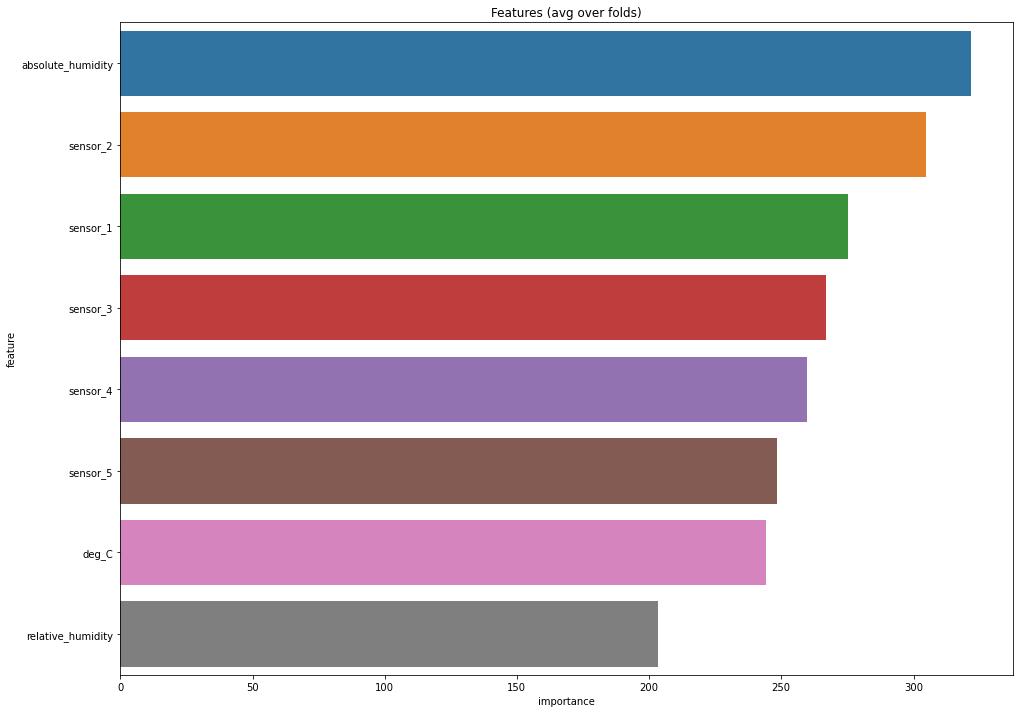

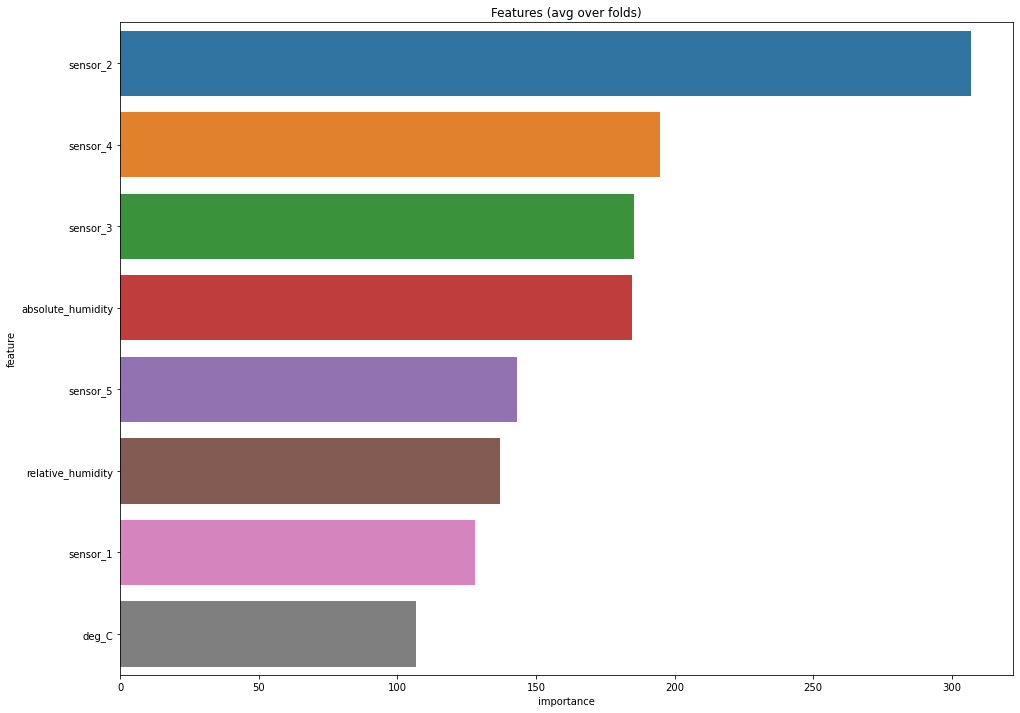

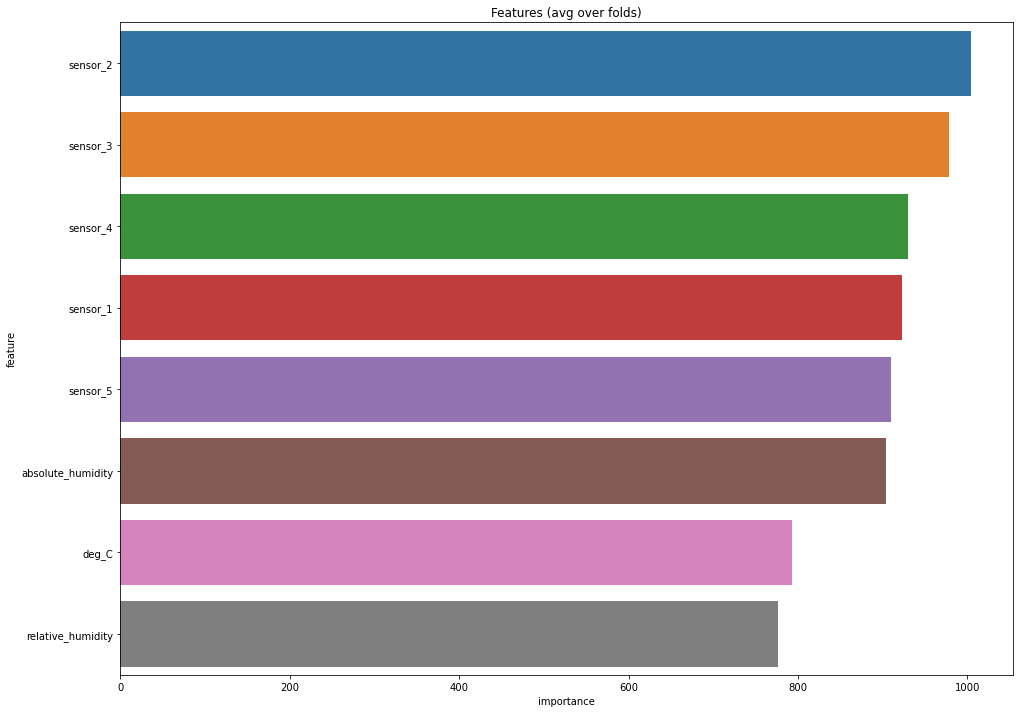

In [13]:
lgb_params = {
                'objective' : 'regression',
                'boosting_type' : 'gbdt',
                'learning_rate' : 0.1,
                'num_leaves' : 31,
                'tree_learner' : 'serial',
                'n_jobs' :-1,
                'seed' : SEED,
                'max_depth' : -1,
                'max_bin' : 255,
                'metric' : 'rmse',
                'verbose' : -1
                }
ts_split = TimeSeriesSplit(n_splits=5, test_size=train_df.shape[0]//5, gap=0)

train_Y = train_Ys["target_carbon_monoxide"]
results_dict_co = model.lgb_train_validate_on_cv(logger, 
                                               run_id=RUN_ID, 
                                               train_X=train_X,
                                               train_Y=train_Y,
                                               test_X=test_X,
                                               num_class=1,
                                               kf = ts_split,
                                               features = predictors,
                                               params = lgb_params,
                                               n_estimators=1000,
                                               early_stopping_rounds=100,
                                               cat_features= "auto",
                                               is_test=False,
                                               verbose_eval=100,
                                               label_name="co"
                                              )
train_index = train_df.index
common.save_artifacts(
    logger,
    is_test=False,
    is_plot_fi=True,
    result_dict=results_dict_co,
    submission_df=sample_submission_df,
    train_index=train_index,
    model_number=MODEL_NAME,
    run_id=RUN_ID,
    sub_dir=constants.SUBMISSION_DIR,
    oof_dir=constants.OOF_DIR,
    fi_dir=constants.FI_DIR,
    fi_fig_dir=constants.FI_FIG_DIR,
    label_name="co"
)


train_Y = train_Ys["target_benzene"]
results_dict_ben = model.lgb_train_validate_on_cv(logger, 
                                               run_id=RUN_ID, 
                                               train_X=train_X,
                                               train_Y=train_Y,
                                               test_X=test_X,
                                               num_class=1,
                                               kf = ts_split,
                                               features = predictors,
                                               params = lgb_params,
                                               n_estimators=1000,
                                               early_stopping_rounds=100,
                                               cat_features= "auto",
                                               is_test=False,
                                               verbose_eval=100,
                                               label_name="ben"
                                              )

train_index = train_df.index
common.save_artifacts(
    logger,
    is_test=False,
    is_plot_fi=True,
    result_dict=results_dict_ben,
    submission_df=sample_submission_df,
    train_index=train_index,
    model_number=MODEL_NAME,
    run_id=RUN_ID,
    sub_dir=constants.SUBMISSION_DIR,
    oof_dir=constants.OOF_DIR,
    fi_dir=constants.FI_DIR,
    fi_fig_dir=constants.FI_FIG_DIR,
    label_name="ben"
)


train_Y = train_Ys["target_nitrogen_oxides"]
results_dict_no = model.lgb_train_validate_on_cv(logger, 
                                               run_id=RUN_ID, 
                                               train_X=train_X,
                                               train_Y=train_Y,
                                               test_X=test_X,
                                               num_class=1,
                                               kf = ts_split,
                                               features = predictors,
                                               params = lgb_params,
                                               n_estimators=1000,
                                               early_stopping_rounds=100,
                                               cat_features= "auto",
                                               is_test=False,
                                               verbose_eval=100,
                                               label_name="no"
                                              )

train_index = train_df.index
common.save_artifacts(
    logger,
    is_test=False,
    is_plot_fi=True,
    result_dict=results_dict_no,
    submission_df=sample_submission_df,
    train_index=train_index,
    model_number=MODEL_NAME,
    run_id=RUN_ID,
    sub_dir=constants.SUBMISSION_DIR,
    oof_dir=constants.OOF_DIR,
    fi_dir=constants.FI_DIR,
    fi_fig_dir=constants.FI_FIG_DIR,
    label_name="no"
)

(agg_oof_score, agg_avg_cv_scores) = common.calculate_final_score(
    RUN_ID, 
    results_dict_co,
    results_dict_ben,
    results_dict_no)

print(f"agg_oof_score: {agg_oof_score}, agg_avg_cv_scores: {agg_avg_cv_scores}")

common.create_submission_file(    
    logger=logger,
    run_id=RUN_ID,
    model_number=MODEL_NAME,
    sub_dir=constants.SUBMISSION_DIR,
    score=agg_avg_cv_scores,
    sub_df=sample_submission_df,
    test_df=test_df,
    results_dict_co=results_dict_co,
    results_dict_ben=results_dict_ben,
    results_dict_no=results_dict_no,)

In [17]:
import numpy as np

In [21]:
(train_Ys == 0).sum()

target_carbon_monoxide    0
target_benzene            0
target_nitrogen_oxides    0
dtype: int64